# Pointwise Cross-Encoder

This is a copy of [`pointwise.ipynb`](./pointwise.ipynb) that attempts to use the MS MARCO
dataset instead, because all the ranking metrics can not be used with mMARCO meaningfully
(as it's lacking more than one pos/neg candidate per query.)

In [1]:
import os
import sys

sys.path.append(os.path.abspath("..")) # make src available as a package

SEED = int(os.getenv("SEED", 42))

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for Apple's Metal (MPS) backend / framework
if torch.backends.mps.is_available():
    device = torch.device("mps")

print(f"Using device: {device}")

Using device: cuda


# 1. Dataset Preparation

In [2]:
from src.data import MSMARCO

batch_size = 16
train_dl, val_dl, test_dl = MSMARCO.as_dataloaders(batch_size=batch_size)

# 2. Training

### Hyperparameters

In [3]:
from src.models import CrossEncoderBERT
import torch.optim as optim
import torch.nn as nn

padding = "longest"
max_length = 512
model = CrossEncoderBERT()
criterion = nn.BCEWithLogitsLoss(reduction="none")
learning_rate = 2e-5
epochs = 3
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)


### Training Loop

In [6]:
from typing import cast
from transformers import BatchEncoding
from src.data.msmarco import MSMARCOBatch
from IPython.display import display
import torch.nn as nn
from src.utils.widgets import Label, Counter, progress_widgets, update_progress, update_loss
from src.utils.stats import Stats
import ipywidgets
import torch


# Turn an MSMARCO batch into pointwise (query, candidate, label) tasks
# - pick one positive (label==1) and one non-positive (prefer 0 else -1) per sample
# - skip samples that don't have both kinds
# Returns flat lists aligned by index and a labels tensor (float, shape (N,))

def to_pointwise(batch: MSMARCOBatch) -> tuple[list[str], list[str], torch.Tensor]:
    queries: list[str] = []
    candidates: list[str] = []
    labels: list[float] = []

    for q, cand_list, lab_list in zip(
        batch["queries"], batch["candidates"], batch["labels"]
    ):
        pos_idxs = [i for i, l in enumerate(lab_list) if l == 1]
        neg0_idxs = [i for i, l in enumerate(lab_list) if l == 0]
        negm_idxs = [i for i, l in enumerate(lab_list) if l == -1]

        if not pos_idxs:
            continue  # no positive => skip
        pi = pos_idxs[0]
        ni = neg0_idxs[0] if len(neg0_idxs) > 0 else (negm_idxs[0] if len(negm_idxs) > 0 else None)
        if ni is None:
            continue  # no non-positive => skip

        # append two pointwise tasks
        queries.append(q)
        candidates.append(cand_list[pi])
        labels.append(1.0)

        queries.append(q)
        candidates.append(cand_list[ni])
        labels.append(0.0)

    return queries, candidates, torch.tensor(labels, dtype=torch.float)


# convenience function for batch tokenization (pointwise)
def tokenize_pointwise(queries: list[str], candidates: list[str]):
    return model.tokenize(
        queries,
        candidates,
        padding=padding,
        max_length=max_length,
    ).to(device)


# convenience function to unpack the BatchEncoding for the model's forward
def feed(input: BatchEncoding):
    return (
        input["input_ids"],
        input["attention_mask"],
        input["token_type_ids"],  # type: ignore
    )

stats = Stats()
widgets = progress_widgets(epochs)
progress_widget = widgets["progress"]
training_loss_widget = widgets["train_loss"]
val_loss_widget = widgets["val_loss"]

# print stats and display widgets
time_label = Label(f"Start: {stats.start.strftime('%H:%M:%S')}" + " Stop: {value}", show=False)
# used for both training and validation ...
batch_counter = Counter("Batches: {value}", show=False) # batches seen per epoch
iter_counter = Counter("Iterations: {value}", show=False) # samples seen per epoch

# Mean loss per epoch (NO rolling window)
train_mean_loss_label = Label("L\u0305: {value:.4f}", show=False) # Mean Loss per epoch
val_mean_loss_label = Label("L\u0305: {value:.4f}", show=False) # Mean Loss per epoch

# Standard Deviation per epoch (rolling window for training)
train_deviation_label = Label("σ: {value:.4f}", show=False)
val_deviation_label = Label("σ: {value:.4f}", show=False)

# Coefficient of Variation per epoch (rolling window for training)
train_cv_label = Label("CV: {value:.2f}%", show=False, transform=lambda x: x * 100) 
val_cv_label = Label("CV: {value:.2f}%", show=False, transform=lambda x: x * 100)

display(ipywidgets.VBox([
    ipywidgets.HBox([time_label.widget]),
    ipywidgets.HBox([progress_widget, batch_counter.widget, iter_counter.widget]),
    ipywidgets.HBox([training_loss_widget, train_mean_loss_label.widget, train_deviation_label.widget, train_cv_label.widget]),
    ipywidgets.HBox([val_loss_widget, val_mean_loss_label.widget, val_deviation_label.widget, val_cv_label.widget])
]))

# GPU => prefer bfloat16, so no GradScaler needed
# CPU/MPS => stick to FP32 (no autocast)
dtype = torch.bfloat16 if device.type == "cuda" else torch.float32
autocast_enabled = device.type == "cuda" # assume GPU is Ampere or later
model.to(device)

for epoch in range(epochs):

    # --- training loop ---
    model.train()
    for idx, batch in enumerate(train_dl):
        batch = cast(MSMARCOBatch, batch)

        queries, candidates, y = to_pointwise(batch)
        if len(queries) == 0:
            continue  # nothing to train on in this batch
        inputs = tokenize_pointwise(queries, candidates)

        optimizer.zero_grad()

        with torch.autocast(device_type=device.type, dtype=dtype, enabled=autocast_enabled):
            logits = model(*feed(inputs)).squeeze(-1)  # (N,)
            losses = criterion(logits, y.to(device))   # (N,)
            
        loss = losses.mean()
        loss.backward()
        optimizer.step()

        # values for UI
        mean_loss = loss.item()

        # - update stats - (ensure CPU list even when running on GPU)
        stats.collect("train", epoch, idx, losses.detach().float().cpu().tolist())
        # - update widgets -
        batch_counter.inc()
        iter_counter.update(len(queries))
        update_loss(mean_loss, training_loss_widget, "Train")
        train_mean_loss_label.set(stats.mean("train", epoch, window=100))
        train_deviation_label.set(stats.std("train", epoch, window=100))
        train_cv_label.set(stats.CV("train", epoch, window=5000))
    

    # after each epoch, reset some widgets / counters
    batch_counter.clear()
    iter_counter.clear()

    # --- validation loop ---
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_dl):
            batch = cast(MSMARCOBatch, batch)
            
            queries, candidates, y = to_pointwise(batch)
            if len(queries) == 0:
                continue
            inputs = tokenize_pointwise(queries, candidates)

            logits = model(*feed(inputs)).squeeze(-1)
            losses = criterion(logits, y.to(device))

            # - update stats -
            stats.collect("val", epoch, idx, losses.detach().float().cpu().tolist())
            # - update widgets -
            batch_counter.inc()
            iter_counter.update(len(queries))
            
            

            update_loss(losses.mean().item(), val_loss_widget, "Val")
            val_mean_loss_label.set(stats.mean("val", epoch, window=100))
            val_deviation_label.set(stats.std("val", epoch, window=100))
            val_cv_label.set(stats.CV("val", epoch, window=5000))


    tr_m, tr_s = stats.mean("train", epoch, window=0), stats.std("train", epoch, window=0)
    train_samples = sum(len(b) for b in stats.train_losses[epoch])
    va_m, va_s = stats.mean("val", epoch, window=0), stats.std("val", epoch, window=0)
    val_samples = sum(len(b) for b in stats.val_losses[epoch])
    print(f"Epoch {epoch} | Train: {tr_m:.4f} ± {tr_s:.4f} (n={train_samples}) | Val: {va_m:.4f} ± {va_s:.4f} (n={val_samples})")

    update_progress(epoch, epochs, progress_widget)
    batch_counter.clear()
    iter_counter.clear()
            
    
model.eval()
stats.stop()
time_label.set(f"{stats.end.strftime('%H:%M:%S')} ({(stats.elapsed/60):.1f}min)") # pyright: ignore[reportOptionalOperand, reportOptionalMemberAccess]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 0 | Train: 0.5126 ± 0.4829 (n=1005876) | Val: 0.4512 ± 0.6383 (n=111156)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 0 | Train: 0.5126 ± 0.4829 (n=1005876) | Val: 0.4512 ± 0.6383 (n=111156)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 0 | Train: 0.5126 ± 0.4829 (n=1005876) | Val: 0.4512 ± 0.6383 (n=111156)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 1 | Train: 0.4649 ± 0.5135 (n=1005876) | Val: 0.4452 ± 0.6186 (n=111156)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 0 | Train: 0.5126 ± 0.4829 (n=1005876) | Val: 0.4512 ± 0.6383 (n=111156)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 1 | Train: 0.4649 ± 0.5135 (n=1005876) | Val: 0.4452 ± 0.6186 (n=111156)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 0 | Train: 0.5126 ± 0.4829 (n=1005876) | Val: 0.4512 ± 0.6383 (n=111156)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 1 | Train: 0.4649 ± 0.5135 (n=1005876) | Val: 0.4452 ± 0.6186 (n=111156)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


KeyboardInterrupt: 

### Saving The Model

In [ ]:
stop_rfc3339 = stats.end.strftime("%Y-%m-%dT%H:%M:%S%Z")  # pyright: ignore[reportOptionalMemberAccess]

In [ ]:
torch.save(model.state_dict(), f"cross-encoder_pointwise_MS_MARCO_{stop_rfc3339}.pth")

### Plotting & Detailed Trainings Run Analysis

The plotting was simplified and the resolution increased compared to the first notebook

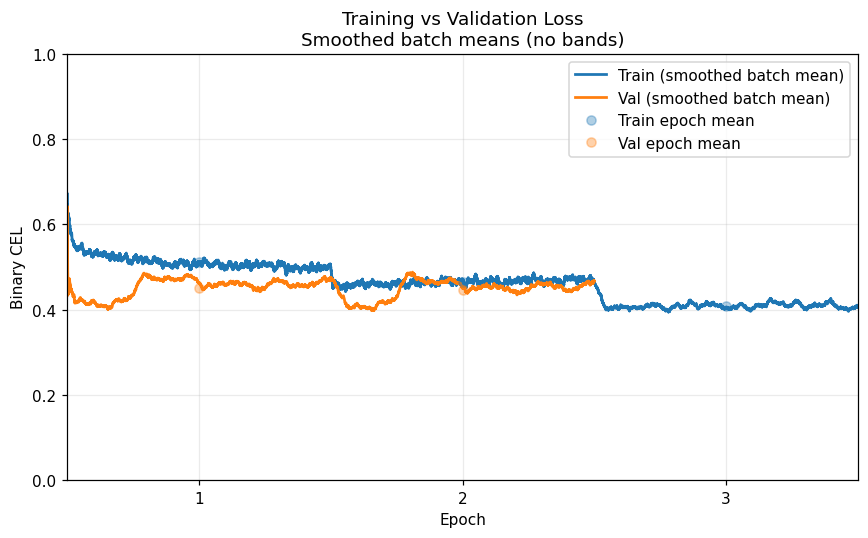

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Higher-resolution loss plot across epochs using batch-level means with smoothing.
# - X axis: epoch with fractional progress, data lie within each epoch interval (e, e+1)
# - Y axis: batch mean loss (smoothed)
# - No bands/STD/CV; just clean, dense curves

SMOOTH_WINDOW = 400  # trailing moving-average window over batch means (in batches)
YMIN, YMAX = 0.0, 1.0


def _batch_time_series(losses_3d: list[list[list[float]]]) -> tuple[list[float], list[float]]:
    """Flatten (epoch, batch, sample) -> parallel lists of (x, y) points.

    x = epoch index with fractional progress in (e, e+1)
    y = mean(losses) for that batch
    """
    xs: list[float] = []
    ys: list[float] = []
    for e, epoch_batches in enumerate(losses_3d):
        nb = len(epoch_batches)
        if nb == 0:
            continue
        for i, batch_losses in enumerate(epoch_batches):
            if not batch_losses:
                continue
            # fractional epoch position inside (e, e+1)
            x = e + (i + 0.5) / nb
            # mean loss of this batch
            y = float(np.mean(np.asarray(batch_losses, dtype=float)))
            xs.append(x)
            ys.append(y)
    return xs, ys


def _moving_average(values: list[float], window: int) -> list[float]:
    if window <= 1:
        return values
    out: list[float] = []
    acc = 0.0
    q: list[float] = []  # simple queue
    for v in values:
        q.append(v)
        acc += v
        if len(q) > window:
            acc -= q.pop(0)
        out.append(acc / len(q))
    return out


# Build time series from recorded stats
train_x, train_y = _batch_time_series(stats.train_losses)
val_x, val_y = _batch_time_series(stats.val_losses)

# Apply smoothing for nicer curves (trailing moving average)
train_y_smooth = _moving_average(train_y, SMOOTH_WINDOW)
val_y_smooth = _moving_average(val_y, SMOOTH_WINDOW)

# Epoch count for axis
num_epochs = max(len(stats.train_losses), len(stats.val_losses))

fig, ax = plt.subplots(figsize=(8, 5), dpi=110)

# Dense, smooth curves
if train_x and train_y_smooth:
    ax.plot(train_x, train_y_smooth, label="Train (smoothed batch mean)", color="C0", linewidth=1.8)
if val_x and val_y_smooth:
    ax.plot(val_x, val_y_smooth, label="Val (smoothed batch mean)", color="C1", linewidth=1.8)

# Optional: show epoch-level mean as light markers for reference
train_epoch_means = [stats.mean("train", e, window=0) for e in range(len(stats.train_losses))]
val_epoch_means = [stats.mean("val", e, window=0) for e in range(len(stats.val_losses))]
ax.plot([e + 0.5 for e in range(len(train_epoch_means))], train_epoch_means, "o", color="C0", alpha=0.35, label="Train epoch mean")
ax.plot([e + 0.5 for e in range(len(val_epoch_means))], val_epoch_means, "o", color="C1", alpha=0.35, label="Val epoch mean")

ax.set_xlabel("Epoch")
ax.set_ylabel("Binary CEL")
ax.set_title("Training vs Validation Loss\nSmoothed batch means (no bands)")
ax.grid(True, alpha=0.25)
ax.set_xlim(0.0, float(num_epochs))
if YMIN is not None and YMAX is not None:
    ax.set_ylim(YMIN, YMAX)
ax.set_xticks([e + 0.5 for e in range(num_epochs)], labels=[str(e + 1) for e in range(num_epochs)])
ax.legend()
ax.margins(x=0.02)
plt.tight_layout()

# plt.savefig(f"training_validation_loss_{stop_rfc3339}.png", dpi=200)
plt.show()


# 3. Evaluation

After the training (and validation) cycles are done,
the reamaining test set is used to report the final
performance as well as actual IR ranking metrics.

In [ ]:
model.eval()
with torch.no_grad():
    total = 0.0
    n = 0
    for batch in test_dl:
        queries, candidates, y = to_pointwise(batch)
        if len(queries) == 0:
            continue
        inputs = tokenize_pointwise(queries, candidates)
        logits = model(*feed(inputs)).squeeze(-1)
        losses = criterion(logits, y.to(device))
        total += float(losses.mean().item())
        n += 1
    if n > 0:
        print(f"Test mean loss: {total/n:.4f}")
    else:
        print("Test had no usable samples.")

Metrics:
- MRR (Mean Reciprocal Rank)
- nDCG@k (Normalized Discounted Cumulative Gain at k)
- MAP (Mean Average Precision)
- Recall@k (or Hit@k)

In [ ]:
from src.metrics import MRR, recall_at

# Build predicted rankings per query for a small sample from MSMARCO's test set,
# then compute IR metrics (MRR and Recall@k).
# Treat label -1 as non-relevant for simplicity.

num_eval_queries = 100  # limit the set for speed
K = 10                  # Recall@K

# predicted order -> 1/0 relevance per query
relevance_lists: list[list[int]] = []

model.eval()
with torch.no_grad():
    collected = 0
    for batch in test_dl:
        qs = batch["queries"]
        cands_batch = batch["candidates"]
        labels_batch = batch["labels"]

        for q, cand_list, lab_list in zip(qs, cands_batch, labels_batch):
            if collected >= num_eval_queries:
                break
            if not cand_list:
                continue

            # convert labels to binary relevance: 1 -> relevant, (0 OR -1) -> not relevant
            rel_bin = [1 if int(l) == 1 else 0 for l in lab_list]
            if sum(rel_bin) == 0:
                # No known positives for this query -> skip
                # bc cannot evaluate rank-based metrics
                continue

            # ccore all candidates for this query
            enc = model.tokenize(
                [q] * len(cand_list),
                list(cand_list),
                padding=padding,
                max_length=max_length,
            ).to(device)

            logits = model(*feed(enc)).squeeze(-1)
            scores = logits.detach().float().cpu().tolist()

            # vuild relevance list in predicted order (descending score)
            order = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
            rel_sorted = [rel_bin[i] for i in order]
            relevance_lists.append(rel_sorted)
            collected += 1
            
        if collected >= num_eval_queries:
            break

if relevance_lists:
    mrr = MRR(relevance_lists)
    r_at_k = recall_at(relevance_lists, k=K)
    print(f"Evaluation on {len(relevance_lists)} test queries (with >=1 positive):")
    print(f"MRR: {mrr:.4f}")
    print(f"Recall@{K}: {r_at_k:.4f}")
else:
    print("No evaluable test queries with positive labels were found; metrics not computed.")

# 4. Inference

In [ ]:
test_query = "What is the capital of France?"
test_candidates = [
    "Paris is the capital of France.",
    "Marseille is a city in France.",
    "Lyon is known for its cuisine.",
    "France is in Europe.",
    "Macron is the president of France.",
    "Berlin is the capital of Germany.",
    "Madrid is the capital of Spain.", 
    "Rome is the capital of Italy."
]

ranked_results = model.rank(test_query, test_candidates, device=device)

for candidate, score in ranked_results:
    print(f"Score: {score:.4f} - Candidate: {candidate}")
    

Score: 0.9888 - Candidate: Paris is the capital of France.
Score: 0.9510 - Candidate: France is in Europe.
Score: 0.2429 - Candidate: Marseille is a city in France.
Score: 0.1734 - Candidate: Rome is the capital of Italy.
Score: 0.1284 - Candidate: Madrid is the capital of Spain.
Score: 0.0412 - Candidate: Lyon is known for its cuisine.
Score: 0.0341 - Candidate: Berlin is the capital of Germany.
Score: 0.0119 - Candidate: Macron is the president of France.


Save this ranking to disk

In [ ]:
filename = f"cross-encoder_pointwise_ranked_{stop_rfc3339}.txt"
with open(filename, "w") as f:
    f.write(f"Query: {test_query}\n\n")
    for candidate, score in ranked_results:
        f.write(f"Score: {score:.4f} - Candidate: {candidate}\n")